# Imports

In [785]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from lens_simulation import Lens, Simulation, utils
from scipy import fftpack
from matplotlib import pyplot as plt
from enum import Enum, auto


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Regular simulation settings

In [786]:
amplitude = 10000
sim_wavelength = 488e-9
sim_width = 1000e-6
pixel_size = 0.1e-6
output_medium = Lens.Medium(1.)

### Convergence/Divergence Class/Functions

In [869]:
class BeamSpread(Enum):
    Plane = auto()
    Diverging = auto()
    Converging = auto()

def theta_from_NA(numerical_aperture: float, output_medium: Lens.Medium):
    import numpy as np
    return np.arcsin(numerical_aperture/output_medium.refractive_index)

def focal_distance_from_theta(aperture: Lens, theta: float):
    return aperture.diameter/2 / np.tan(theta)

def height_from_focal_distance(aperture: Lens, output_medium: Lens.Medium, focal_distance: float):
    a = 1
    b = -2*focal_distance*(aperture.medium.refractive_index-output_medium.refractive_index)/output_medium.refractive_index
    c = (aperture.diameter/2)**2

    if (b**2 - 4*a*c < 0):
        raise ValueError("Negative value encountered in sqrt.  Can't find a lens height to give this focal distance")
    else: return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

### Aperture/Beam definition

In [842]:
# Beam settings chosen by user
aperture_width = 600e-6
# position given relative to optical axis
aperture_position = 0e-6
# perpendicular distance from the lens
aperture_distance = 100e-6

# quick check on aperture validity
if (aperture_position + aperture_width/2) > sim_width:
    raise ValueError('Aperture cannot exist outside of simulation') 

# type of beam spread
beam_spread = BeamSpread.Converging

# change from focusing to planar if plane wave beam
if beam_spread == BeamSpread.Plane:
    exponent = 1.
else:
    exponent = 2.

# Default beam specifications
aperture = Lens.Lens(
    diameter=aperture_width,
    height=0.,
    exponent=exponent,
    medium=Lens.Medium(100)
)

#### Convergence/Divergence Settings

In [843]:
if beam_spread is not BeamSpread.Plane:
    # Theta can either be specified directly, or by numerical aperture (config flag probably)
    theta = np.deg2rad(10) 
    # OR
    theta = theta_from_NA(numerical_aperture=0.4, output_medium=output_medium)

#### Calculation of Convergence/Divergence

In [868]:
if beam_spread is not BeamSpread.Plane:
    # calculate the equivalent focal distance of the required convergence angle
    focal_distance = focal_distance_from_theta(aperture=aperture, theta=theta)

    # calculate and set the height of the apertures 'virtual' lens, re-generate the profile with new height
    aperture.height = height_from_focal_distance(aperture, output_medium=output_medium, focal_distance=focal_distance)
    
    printing = False
    if printing:
        # Just some debugging prints, can remove if you want
        print(f'Angle of convergence: {np.rad2deg(theta)}')
        print(f'Focal distance wanted: {round(focal_distance*1e3, 3)}mm')
        print(f'Aperture height: {round(aperture.height*1e6, 3)}um')
        print(f'New Focal Distance: {round(Simulation.calculate_equivalent_focal_distance(aperture, output_medium)*1e3, 3)}mm')

aperture.generate_profile(pixel_size=pixel_size)

# calculate the relative position of the aperture in pixels
relative_position = int(aperture_position/pixel_size)

# pad the aperture to the sim width
# plus one here is to make it 10001, not 9999
pad_width = (int(sim_width/pixel_size)-len(aperture.profile))//2 + 1 

# update the aperture profile
aperture.profile = np.pad(aperture.profile, (pad_width+relative_position, pad_width-relative_position), 'constant', constant_values=(0))
# plt.plot(aperture.profile)

In [864]:
# Standard mode for plane (with minimised )


# The standard mode for Convergence
start_distance = focal_distance * 0
finish_distance = focal_distance * 1

# if you want the beam to converge to a specific width
beam_width = 200e-6
if beam_spread is BeamSpread.Converging and beam_width is not None:
    beam_radius = beam_width/2
    finish_distance = focal_distance - (beam_radius/np.tan(theta))

# finish_distance_1 = focal_distance-(l_radius/np.tan(theta))
finish_distance_1 = focal_distance * 1#-(l_radius/np.tan(theta))
# 
# plt.plot(aperture.profile)
delta_1 = (aperture.medium.refractive_index-output_medium.refractive_index) * aperture.profile


In [865]:
plt.figure()
x = np.arange(len(aperture.profile))*pixel_size
delta_1 = delta_1 + x * np.tan(np.deg2rad(15))
# plt.plot(delta_1)
phase_1 = (2 * np.pi * delta_1 / sim_wavelength) % (2 * np.pi)

wavefront_1 = amplitude * np.exp(1j * phase_1)

wavefront_1[:pad_width + relative_position] = 0 + 0j
wavefront_1[-(pad_width - relative_position):] = 0 + 0j

wavefront_1 = fftpack.fft(wavefront_1)

<Figure size 432x288 with 0 Axes>

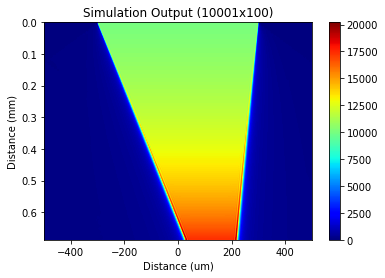

In [866]:
# regular frequency array creation
frequency_array = Simulation.generate_squared_frequency_array(n_pixels=len(aperture.profile), pixel_size=pixel_size)

n_slices_1 = 100

sim_1 = np.ones(shape=((n_slices_1), len(aperture.profile)))
distances_1 = np.linspace(start_distance, finish_distance, n_slices_1)
for i, z in enumerate(distances_1):
    prop_1 = np.exp(1j * output_medium.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array) / output_medium.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop_1 * wavefront_1)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)

    sim_1[i] = np.round(output, 10)


utils.plot_simulation(sim_1, sim_1.shape[1], sim_1.shape[0], pixel_size, start_distance, finish_distance_1)
plt.show()
# # passed_wavefront = propagation


# DIVERGING CASE

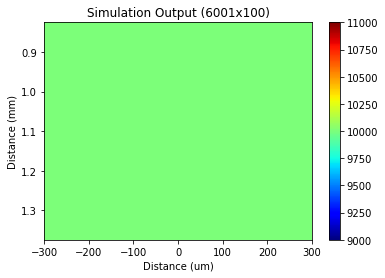

In [476]:

wavefront_1 = A * np.exp(1j * phase_1)
wavefront_1 = fftpack.fft(wavefront_1)

n_slices_1 = 100

start_distance_1 = focal_distance * 1.2
# start_distance_1 = 0
# finish_distance_1 = focal_distance + (l_radius/np.tan(theta))
finish_distance_1 = focal_distance * 2

sim_1 = np.ones(shape=((n_slices_1), len(lens.profile)))
distances_1 = np.linspace(start_distance_1, finish_distance_1, n_slices_1)
for i, z in enumerate(distances_1):
    prop_1 = np.exp(1j * medium.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array_1) / medium.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop_1 * wavefront_1)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)

    sim_1[i] = np.round(output, 10)

from lens_simulation import utils
utils.plot_simulation(sim_1, sim_1.shape[1], sim_1.shape[0], pixel_size, start_distance_1, finish_distance_1)
plt.show()
passed_wavefront = propagation


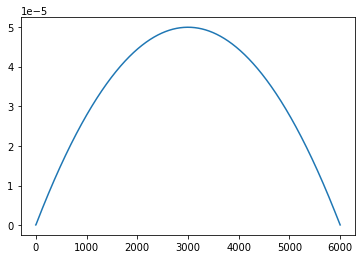

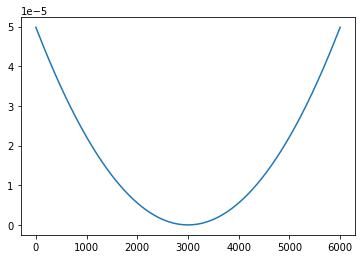

In [349]:
lens.generate_profile(pixel_size=pixel_size)
plt.plot(lens.profile)

lens.profile = -lens.profile + np.max(lens.profile) 
plt.figure()
plt.plot(lens.profile)



0.0001


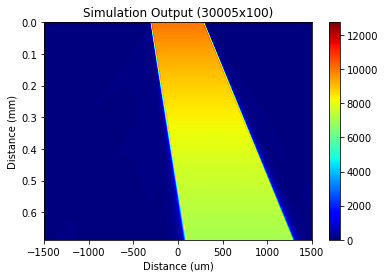

In [389]:
start_distance_1 = focal_distance * 0.
l_r = lens.diameter/2
print(l_width)
finish_distance_1 = focal_distance
# finish_distance_1 = focal_distance*((l_width*2-l_r)/(l_r))
# finish_distance_1 = focal_distance-(l_radius/np.tan(theta))
# finish_distance_1 = focal_distance#-(l_radius/np.tan(theta))
lens.generate_profile(pixel_size=pixel_size)
lens.profile = abs(lens.profile - np.max(lens.profile)) 
pad_px = 4 * len(lens.profile)//2
lens.profile = np.pad(lens.profile, pad_px)
frequency_array_1 = Simulation.generate_squared_frequency_array(
    n_pixels=len(lens.profile), pixel_size=pixel_size)

lens.medium = Lens.Medium(2.348)
delta_1 = (lens.medium.refractive_index-medium.refractive_index) * lens.profile

x = np.arange(len(lens.profile))*pixel_size

delta_1 = delta_1 + x * np.tan(np.deg2rad(45))
phase_1 = (2 * np.pi * delta_1 / sim_wavelength) % (2 * np.pi)

wavefront_1 = A * np.exp(1j * phase_1) #* passed_wavefront
wavefront_1 [0:pad_px] = 0 + 0j
wavefront_1 [-pad_px:] = 0 + 0j
wavefront_1 = fftpack.fft(wavefront_1)

n_slices_1 = 100

sim_1 = np.ones(shape=((n_slices_1), len(lens.profile)))
distances_1 = np.linspace(start_distance_1, finish_distance_1, n_slices_1)
for i, z in enumerate(distances_1):
    prop_1 = np.exp(1j * medium.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array_1) / medium.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop_1 * wavefront_1)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)

    sim_1[i] = np.round(output, 10)
    # sim_1[i] = np.clip(np.round(output, 10), 0, 10000)

from lens_simulation import utils
utils.plot_simulation(sim_1, sim_1.shape[1], sim_1.shape[0], pixel_size, start_distance_1, finish_distance_1)
plt.show()
passed_wavefront = propagation
sim_2 = sim_1


In [351]:
print(len(lens.profile))

12001


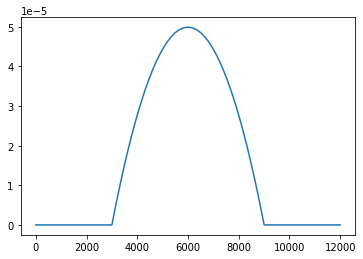

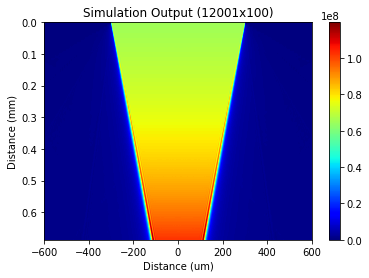

In [352]:
start_distance_1 = focal_distance * 0.
finish_distance_1 = focal_distance * 1.#-(l_radius/np.tan(theta))
# finish_distance_1 = focal_distance#-(l_radius/np.tan(theta))
lens.generate_profile(pixel_size=pixel_size)
# lens.profile = abs(lens.profile - np.max(lens.profile)) 

lens.profile = np.pad(lens.profile, pad_px)
plt.figure()
plt.plot(lens.profile)
frequency_array_1 = Simulation.generate_squared_frequency_array(
    n_pixels=len(lens.profile), pixel_size=pixel_size)

delta_1 = (lens.medium.refractive_index-medium.refractive_index) * lens.profile
phase_1 = (2 * np.pi * delta_1 / sim_wavelength) % (2 * np.pi)

wavefront_1 = A * np.exp(1j * phase_1) * passed_wavefront
wavefront_1 [0:pad_px] = 0 + 0j
wavefront_1 [-pad_px:] = 0 + 0j
wavefront_1 = fftpack.fft(wavefront_1)

n_slices_1 = 100

sim_1 = np.ones(shape=((n_slices_1), len(lens.profile)))
distances_1 = np.linspace(start_distance_1, finish_distance_1, n_slices_1)
for i, z in enumerate(distances_1):
    prop_1 = np.exp(1j * medium.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array_1) / medium.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop_1 * wavefront_1)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)

    sim_1[i] = np.clip(np.round(output, 10), 0, 10000)
    sim_1[i] = np.round(output, 10)

from lens_simulation import utils
utils.plot_simulation(sim_1, sim_1.shape[1], sim_1.shape[0], pixel_size, start_distance_1, finish_distance_1)
plt.show()
# passed_wavefront = propagation


True
False
(array([ 1,  1,  1, ..., 99, 99, 99], dtype=int64), array([   13,    34,    37, ..., 11995, 11996, 11998], dtype=int64))


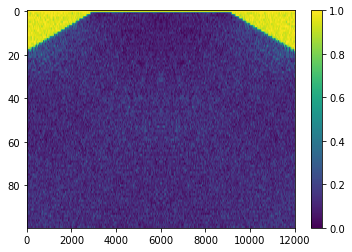

In [315]:
print(np.allclose(sim_2, sim_1, rtol=0.0000001))
print(np.array_equal(sim_2, sim_1))
plt.figure()
plt.imshow((np.equal(sim_2, sim_1)), aspect='auto')
plt.colorbar()

a = np.where(np.equal(sim_2, sim_1)== 0) 
print(a)
# print(a[0])